# Tries

# v.4 id by id

In [ ]:
## Replace Values zero in Score column based on Condition
#df_copy['Scored_by'] = (np.where(df_copy['Scored_by']==0,df_copy['Scored_by'].replace(0,np.nan).
#                groupby(df_copy['Source']).transform('median'),df_copy['Scored_by']))
#

In [ ]:
## Replace Values zero in Score column based on Condition
#df_copy['Score'] = (np.where(df_copy['Score']==0,df_copy['Score'].replace(0,np.nan).
#                groupby(df_copy['Source']).transform('median'),df_copy['Score']))

In [23]:
# Import Libraries
import requests, json, os, sys, time
import pandas as pd
from datetime import datetime
#Preparing time variables to later save documents
current_time = time.strftime("%H_%M_%S",time.localtime())
date = datetime.now()
actual_date = date.strftime("%Y_%m_%d")
#Preparing folder variables
os.chdir(os.path.dirname(sys.path[0])) # Este comando hace que el notebook sea la ruta principal y poder trabajar en cascada
folder_path = sys.path[0]
data_path = os.path.join(folder_path,"data")
logs_path = os.path.join(data_path,"logs")
#Remove the limit to see the df
pd.set_option('display.max_columns', None)
#Creating the necessary lists
anime_list = []
missing_requests_list = []
resource_does_not_exist = []
'''
Creates the folders needed to store data for the current day (in case the folders does not exist).
'''
def create_folder(name):
    try:
        os.makedirs(os.path.join(folder_path,str(name)))
    except FileExistsError:
        print("The folder data already exist")
        pass
    try:
        os.mkdir(os.path.join(data_path,str("logs")))
        print("The folder",str("logs" +'_'+ actual_date),"was created")
    except FileExistsError:
        print("The folder",str(name +'_'+ actual_date),"already exist")
        pass
create_folder("data")
#Def to check if there is an empty value. If the category is empty, it returns None
def try_it(i):
    try:
        return i["name"]
    except:
        return None
#Def with a try check to get the finishing time of an anime, in case the anime is a movie, then it returns the release time.
# If the anime is not a movie, it checks for the finishing time. If there is no finishing time, it returns None 
def movie():
    try:
        if ( data["type"] == "Movie" or data["type"] == "OVA" or data["type"] == "Special" or data["type"] == "Music"):
            return data["aired"]["prop"]["from"]["year"]
        elif data["status"] == "Currently Airing":
            return 999 #Still Airing
        elif data["aired"]["prop"]["to"]["year"] == None:
            return 666 # There is no information
        else:
            return data["aired"]["prop"]["to"]["year"]
    except:
        return 0 #No information about it
for id in range (1,25850): #Already 1 to 13000 of 25850 #Loop to go thru a range of chosen numbers
    time.sleep(1)
    try: # First try yo check if the page exist or not
        
        respuesta = requests.get(f"https://api.jikan.moe/v4/anime/{id}") # request to a web page (url)
        
        content = respuesta.json() # creating a variable for all the info we get
        data = content["data"] # Another variable to specify the position of the data we will get
        print (f"Page: {id}") # A print to know where we are
        # Creation of the necessary dictionary o store the values in each loop # We specify which information to get in each Item
        anime_dict = {"Cover" : data["images"]["jpg"]["large_image_url"] if data["images"]["jpg"]["large_image_url"]  else None,
                    "English_Title" : data["titles"][0]["title"] if data["titles"][0]["title"]  else None,
                    "Japanses_Title" : data["title_japanese"] if data["title_japanese"]  else None,
                    "Type" : data["type"] if data["type"]  else None,
                    "Source" : data["source"] if data["status"] else None,
                    "Audience" : [try_it(i) for i in data["demographics"]], # List comprehension calling the Def try_it
                    "N_Episodes" : (int(data["episodes"])) if data["episodes"] else 0,
                    "Duration" : data["duration"] if data["duration"]  else None,
                    "Status" : data["status"] if data["status"] else None,
                    "Rating" : data["rating"] if data["rating"] else None,
                    "Score" : data["score"] if data["score"]  else None,
                    "Scored_by" : data["scored_by"] if data["scored_by"]  else None,
                    "Rank" : (int(data["rank"])) if data["rank"] else None,
                    "Season" : data["season"] if data["season"] else None,
                    "Genre" : [try_it(i) for i in data["genres"]],# List comprehension calling the Def try_it
                    "Theme" : [try_it(i) for i in data["themes"]],# List comprehension calling the Def try_it
                    "Released" : (int(data["aired"]["prop"]["from"]["year"])) if data["aired"]["prop"]["from"]["year"] else None, # If else in one line
                    "Finished" : int(movie()), 
                    "Studios" : [try_it(i) for i in data["studios"]],# List comprehension calling the Def try_it
                    # "Licensors" : [try_it(i) for i in data["licensors"]],# List comprehension calling the Def try_it
                    "Producers" : [try_it(i) for i in data["producers"]]# List comprehension calling the Def try_it
                    }
                    
        anime_list.append(anime_dict) # Append the loop info to anime_list
        #time.sleep(1) # we use here a time sleep cuz if we are to fast asking for information, the server might block us
    # Ending of the first try specifying the error
    except:
        if respuesta.status_code == 429: #If there is a 429 error we show it on screen and tell us the respuesta.reason
            missing_requests_list.append(id)
            print (f"El código de estado de la petición es: {respuesta.status_code}. Estatus {respuesta.reason}. No se puede recoger información de la página {id}\n")
        else:
            resource_does_not_exist.append(id) #If there is a any other error we show it on screen and tell us the respuesta.reason
            print (f"El código de estado de la petición es: {respuesta.status_code}. Estatus {respuesta.reason}. No se puede recoger información de la página {id}\n")
        continue
# We create df from resource_does_not_exist list and save it in a csv file adding actual date and time variables to the name
resource_does_not_exist_df = pd.DataFrame(resource_does_not_exist)
not_exist_csv = os.path.join(logs_path, "resource_does_not_exist_" + actual_date+ "_" +current_time + ".csv")
resource_does_not_exist_df.to_csv(not_exist_csv , sep = ',', index = False)
print(f'resource_does_not_exist_{actual_date}{current_time}.csv saved into a csv file\n\n')
# We create df from missing_requests_list list and save it in a csv file adding actual date and time variables to the name
missing_requests_df = pd.DataFrame(missing_requests_list)
missing_csv = os.path.join(logs_path, "missing_requests_" + actual_date+ "_" +current_time + ".csv")
missing_requests_df.to_csv(missing_csv, sep = ',', index = False)
print(f'missing_requests_{actual_date}{current_time}.csv saved into a csv file\n\n')
# We create df from anime_list and save it in a csv file adding actual date and time variables to the name
anime_df = pd.DataFrame(anime_list)
anime_csv = os.path.join(data_path, "anime_" + actual_date+ "_" +current_time + ".csv")
anime_df.to_csv(anime_csv, sep = ';', index = False)
print(f'anime_{actual_date}{current_time}.csv created\n\n')

The folder data already exist
The folder data_2022_11_20 already exist


TypeError: 'int' object is not iterable

In [3]:
for i, l in enumerate(anime_df["Audience"]):
    print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>
list 10 is <class 'list'>
list 11 is <class 'list'>
list 12 is <class 'list'>
list 13 is <class 'list'>
list 14 is <class 'list'>
list 15 is <class 'list'>
list 16 is <class 'list'>
list 17 is <class 'list'>
list 18 is <class 'list'>
list 19 is <class 'list'>
list 20 is <class 'list'>
list 21 is <class 'list'>
list 22 is <class 'list'>
list 23 is <class 'list'>
list 24 is <class 'list'>
list 25 is <class 'list'>
list 26 is <class 'list'>
list 27 is <class 'list'>
list 28 is <class 'list'>
list 29 is <class 'list'>
list 30 is <class 'list'>
list 31 is <class 'list'>
list 32 is <class 'list'>
list 33 is <class 'list'>
list 34 is <class 'list'>
list 35 is <class 'list'>
list 36 is <class 'list'>
list 37 is <class 'list'>
list 38 is <class 'lis

In [1]:
anime_df

NameError: name 'anime_df' is not defined

# Checking and Cleaning

### print number TOTAL of null values in the df

In [171]:
anime_df.isna().sum().sum()

3081

### Checking no noll values of every column and dtypes

In [10]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cover           12 non-null     object 
 1   English_Title   12 non-null     object 
 2   Japanses_Title  12 non-null     object 
 3   Type            12 non-null     object 
 4   Source          12 non-null     object 
 5   Audience        12 non-null     object 
 6   N_Episodes      12 non-null     int64  
 7   Duration        12 non-null     object 
 8   Status          12 non-null     object 
 9   Rating          12 non-null     object 
 10  Score           12 non-null     float64
 11  Scored_by       12 non-null     int64  
 12  Rank            12 non-null     int64  
 13  Season          11 non-null     object 
 14  Genre           12 non-null     object 
 15  Theme           12 non-null     object 
 16  Released        12 non-null     int64  
 17  Finished        12 non-null     int64

###  print number of null values by column

In [11]:
anime_df.isna().sum()

Cover             0
English_Title     0
Japanses_Title    0
Type              0
Source            0
Audience          0
N_Episodes        0
Duration          0
Status            0
Rating            0
Score             0
Scored_by         0
Rank              0
Season            1
Genre             0
Theme             0
Released          0
Finished          0
Studios           0
Producers         0
dtype: int64

### Print cells with null values

In [ ]:
anime_df.isnull()

### Removing []

In [13]:
non_numeric = ["Audience","Genre","Theme","Studios","Producers"]
for column in non_numeric:
    anime_df[column] = anime_df[column].str.join(',')
anime_df

,Cover,English_Title,Japanses_Title,Type,Source,Audience,N_Episodes,Duration,Status,Rating,Score,Scored_by,Rank,Season,Genre,Theme,Released,Finished,Studios,Producers
0,https://cdn.myanimelist.net/images/anime/4/196...,Cowboy Bebop,カウボーイビバップ,TV,Original,,26,24 min per ep,Finished Airing,R - 17+ (violence & profanity),8.75,871198,38,spring,"Action,Sci-Fi","Adult Cast,Space",1998,1999,Sunrise,Bandai Visual
1,https://cdn.myanimelist.net/images/anime/1439/...,Cowboy Bebop: Tengoku no Tobira,カウボーイビバップ 天国の扉,Movie,Original,,1,1 hr 55 min,Finished Airing,R - 17+ (violence & profanity),8.38,198943,182,None,"Action,Sci-Fi","Adult Cast,Space",2001,2001,Bones,"Sunrise,Bandai Visual"
2,https://cdn.myanimelist.net/images/anime/7/203...,Trigun,トライガン,TV,Manga,Shounen,26,24 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.22,338827,318,spring,"Action,Adventure,Comedy,Drama,Sci-Fi",Adult Cast,1998,1998,Madhouse,Victor Entertainment
3,https://cdn.myanimelist.net/images/anime/10/19...,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,Original,,26,25 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.25,42098,2754,summer,"Action,Drama,Mystery,Supernatural",Detective,2002,2002,Sunrise,"TV Tokyo,Bandai Visual,Dentsu,Victor Entertain..."
4,https://cdn.myanimelist.net/images/anime/7/215...,Bouken Ou Beet,冒険王ビィト,TV,Manga,Shounen,52,23 min per ep,Finished Airing,PG - Children,6.94,6306,4222,fall,"Adventure,Fantasy,Supernatural",,2004,2005,Toei Animation,"TV Tokyo,Dentsu"
5,https://cdn.myanimelist.net/images/anime/12/66...,Eyeshield 21,アイシールド21,TV,Manga,Shounen,145,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.92,84655,694,spring,Sports,Team Sports,2005,2008,Gallop,"TV Tokyo,Nihon Ad Systems,TV Tokyo Music,Shueisha"
6,https://cdn.myanimelist.net/images/anime/11/73...,Hachimitsu to Clover,ハチミツとクローバー,TV,Manga,Josei,24,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.01,80239,568,spring,"Comedy,Drama,Romance,Slice of Life","Love Polygon,Visual Arts",2005,2005,J.C.Staff,"Dentsu,Genco,Fuji TV,Asmik Ace,Shueisha"
7,https://cdn.myanimelist.net/images/anime/12/49...,Hungry Heart: Wild Striker,ハングリーハート Wild Striker,TV,Manga,Shounen,52,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.55,12693,1545,fall,"Comedy,Slice of Life,Sports",Team Sports,2002,2003,Nippon Animation,
8,https://cdn.myanimelist.net/images/anime/9/105...,Initial D Fourth Stage,頭文字〈イニシャル〉D FOURTH STAGE,TV,Manga,Seinen,24,27 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.15,92257,395,spring,"Action,Drama",Racing,2004,2006,A.C.G.T.,"OB Planning,Studio Jack"
9,https://cdn.myanimelist.net/images/anime/10/18...,Monster,モンスター,TV,Manga,Seinen,74,24 min per ep,Finished Airing,R+ - Mild Nudity,8.85,328893,25,spring,"Drama,Mystery,Suspense","Adult Cast,Psychological",2004,2005,Madhouse,"VAP,Shogakukan-Shueisha Productions,Nippon Tel..."


### Replacing empty space with NaN

In [14]:
import numpy as np
anime_df = anime_df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

### Replacing nan with ZEROS in numerical columns

In [15]:
list_num = ["N_Episodes","Score","Rank","Released","Finished"]
for cat in list_num:
    anime_df[list_num] = anime_df[list_num].fillna(0)

### Checking missing values and the total records

### Checking missing values and the total records after dropping records and cleaning others

In [17]:
anime_df.describe()

,N_Episodes,Score,Scored_by,Rank,Released,Finished
count,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000
mean,55.833333,8.055833,4.174488e+05,950.083333,2002.000000,1919.833333
std,64.724357,0.588317,5.667820e+05,1294.260369,2.558409,290.003709
min,0.000000,6.940000,6.306000e+03,25.000000,1998.000000,999.000000
25%,24.000000,7.827500,7.070375e+04,151.250000,2000.500000,2000.500000
50%,26.000000,8.080000,1.456000e+05,481.500000,2002.000000,2004.000000
75%,57.500000,8.452500,4.719198e+05,906.750000,2004.000000,2005.250000
max,220.000000,8.850000,1.806997e+06,4222.000000,2005.000000,2008.000000


# Descriptive Analysis

### Top 10 animes by rating (voted by member)

In [19]:
anime_df.sort_values(by = 'Rating', ascending = False).head(10)

,Cover,English_Title,Japanses_Title,Type,Source,Audience,N_Episodes,Duration,Status,Rating,Score,Scored_by,Rank,Season,Genre,Theme,Released,Finished,Studios,Producers
9,https://cdn.myanimelist.net/images/anime/10/18...,Monster,モンスター,TV,Manga,Seinen,74,24 min per ep,Finished Airing,R+ - Mild Nudity,8.85,328893,25,spring,"Drama,Mystery,Suspense","Adult Cast,Psychological",2004,2005,Madhouse,"VAP,Shogakukan-Shueisha Productions,Nippon Tel..."
0,https://cdn.myanimelist.net/images/anime/4/196...,Cowboy Bebop,カウボーイビバップ,TV,Original,NaN,26,24 min per ep,Finished Airing,R - 17+ (violence & profanity),8.75,871198,38,spring,"Action,Sci-Fi","Adult Cast,Space",1998,1999,Sunrise,Bandai Visual
1,https://cdn.myanimelist.net/images/anime/1439/...,Cowboy Bebop: Tengoku no Tobira,カウボーイビバップ 天国の扉,Movie,Original,NaN,1,1 hr 55 min,Finished Airing,R - 17+ (violence & profanity),8.38,198943,182,None,"Action,Sci-Fi","Adult Cast,Space",2001,2001,Bones,"Sunrise,Bandai Visual"
2,https://cdn.myanimelist.net/images/anime/7/203...,Trigun,トライガン,TV,Manga,Shounen,26,24 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.22,338827,318,spring,"Action,Adventure,Comedy,Drama,Sci-Fi",Adult Cast,1998,1998,Madhouse,Victor Entertainment
3,https://cdn.myanimelist.net/images/anime/10/19...,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,Original,NaN,26,25 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.25,42098,2754,summer,"Action,Drama,Mystery,Supernatural",Detective,2002,2002,Sunrise,"TV Tokyo,Bandai Visual,Dentsu,Victor Entertain..."
5,https://cdn.myanimelist.net/images/anime/12/66...,Eyeshield 21,アイシールド21,TV,Manga,Shounen,145,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.92,84655,694,spring,Sports,Team Sports,2005,2008,Gallop,"TV Tokyo,Nihon Ad Systems,TV Tokyo Music,Shueisha"
6,https://cdn.myanimelist.net/images/anime/11/73...,Hachimitsu to Clover,ハチミツとクローバー,TV,Manga,Josei,24,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.01,80239,568,spring,"Comedy,Drama,Romance,Slice of Life","Love Polygon,Visual Arts",2005,2005,J.C.Staff,"Dentsu,Genco,Fuji TV,Asmik Ace,Shueisha"
7,https://cdn.myanimelist.net/images/anime/12/49...,Hungry Heart: Wild Striker,ハングリーハート Wild Striker,TV,Manga,Shounen,52,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.55,12693,1545,fall,"Comedy,Slice of Life,Sports",Team Sports,2002,2003,Nippon Animation,NaN
8,https://cdn.myanimelist.net/images/anime/9/105...,Initial D Fourth Stage,頭文字〈イニシャル〉D FOURTH STAGE,TV,Manga,Seinen,24,27 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.15,92257,395,spring,"Action,Drama",Racing,2004,2006,A.C.G.T.,"OB Planning,Studio Jack"
10,https://cdn.myanimelist.net/images/anime/13/17...,Naruto,ナルト,TV,Manga,Shounen,220,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.98,1806997,601,fall,"Action,Adventure,Fantasy",Martial Arts,2002,2007,Pierrot,"TV Tokyo,Aniplex,Shueisha"


### Top 10 animes by members voted

In [ ]:
anime_df.sort_values(by = 'Scored_by', ascending = False).head(10)

### Top 10 animes with more episodes

In [26]:
anime_df.sort_values(by = 'N_Episodes', ascending = False).head(25)

,Cover,English_Title,Japanses_Title,Type,Source,Audience,N_Episodes,Duration,Status,Rating,Score,Scored_by,Rank,Season,Genre,Theme,Released,Finished,Studios,Producers
10,https://cdn.myanimelist.net/images/anime/13/17...,Naruto,ナルト,TV,Manga,Shounen,220,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.98,1806997,601,fall,"Action,Adventure,Fantasy",Martial Arts,2002,2007,Pierrot,"TV Tokyo,Aniplex,Shueisha"
5,https://cdn.myanimelist.net/images/anime/12/66...,Eyeshield 21,アイシールド21,TV,Manga,Shounen,145,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.92,84655,694,spring,Sports,Team Sports,2005,2008,Gallop,"TV Tokyo,Nihon Ad Systems,TV Tokyo Music,Shueisha"
9,https://cdn.myanimelist.net/images/anime/10/18...,Monster,モンスター,TV,Manga,Seinen,74,24 min per ep,Finished Airing,R+ - Mild Nudity,8.85,328893,25,spring,"Drama,Mystery,Suspense","Adult Cast,Psychological",2004,2005,Madhouse,"VAP,Shogakukan-Shueisha Productions,Nippon Tel..."
4,https://cdn.myanimelist.net/images/anime/7/215...,Bouken Ou Beet,冒険王ビィト,TV,Manga,Shounen,52,23 min per ep,Finished Airing,PG - Children,6.94,6306,4222,fall,"Adventure,Fantasy,Supernatural",NaN,2004,2005,Toei Animation,"TV Tokyo,Dentsu"
7,https://cdn.myanimelist.net/images/anime/12/49...,Hungry Heart: Wild Striker,ハングリーハート Wild Striker,TV,Manga,Shounen,52,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.55,12693,1545,fall,"Comedy,Slice of Life,Sports",Team Sports,2002,2003,Nippon Animation,NaN
0,https://cdn.myanimelist.net/images/anime/4/196...,Cowboy Bebop,カウボーイビバップ,TV,Original,NaN,26,24 min per ep,Finished Airing,R - 17+ (violence & profanity),8.75,871198,38,spring,"Action,Sci-Fi","Adult Cast,Space",1998,1999,Sunrise,Bandai Visual
2,https://cdn.myanimelist.net/images/anime/7/203...,Trigun,トライガン,TV,Manga,Shounen,26,24 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.22,338827,318,spring,"Action,Adventure,Comedy,Drama,Sci-Fi",Adult Cast,1998,1998,Madhouse,Victor Entertainment
3,https://cdn.myanimelist.net/images/anime/10/19...,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,Original,NaN,26,25 min per ep,Finished Airing,PG-13 - Teens 13 or older,7.25,42098,2754,summer,"Action,Drama,Mystery,Supernatural",Detective,2002,2002,Sunrise,"TV Tokyo,Bandai Visual,Dentsu,Victor Entertain..."
6,https://cdn.myanimelist.net/images/anime/11/73...,Hachimitsu to Clover,ハチミツとクローバー,TV,Manga,Josei,24,23 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.01,80239,568,spring,"Comedy,Drama,Romance,Slice of Life","Love Polygon,Visual Arts",2005,2005,J.C.Staff,"Dentsu,Genco,Fuji TV,Asmik Ace,Shueisha"
8,https://cdn.myanimelist.net/images/anime/9/105...,Initial D Fourth Stage,頭文字〈イニシャル〉D FOURTH STAGE,TV,Manga,Seinen,24,27 min per ep,Finished Airing,PG-13 - Teens 13 or older,8.15,92257,395,spring,"Action,Drama",Racing,2004,2006,A.C.G.T.,"OB Planning,Studio Jack"


## Library Imports

# Visual Analysis

In [23]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

### Checking missing values and the total records

## Library Imports

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

## Plotting Ideas

Ideas: 
Unidimensional
- For Score a sns.displot and sns.boxplot
- For Episodes a describe and sns.boxplot
- Fro duration: convert to number, then  sns.displot and sns.boxplot
- Genres: Top 10. sns.barplot
- Producers: Top 10. sns.barplot
- Licensors: Top 10. sns.barplot
- Studios: Top 10. sns.barplot
- Rating: .value_counts() and sns.countplot o treemap
- Released:  Top 10.  sns.barplot. Tree map with types?
- Season:  sns.barplot??

Bidimensional
- Score v Episodes corr. scatterplot?
- Score v Duration corr. scatterplot?
- Genres (all) v Score boxplot?
- Genre (top10) boxplot top 10
- BOXPLOT OF TOP10 PRODUCERS v Score
- Producers v Score
- Type v Score boxplot
- BOXPLOT OF TOP10 Studio v Score
- Studio v Score

In [113]:
anime_copy = anime_df.copy()

In [ ]:
Genres = anime_copy2['Genre'].str.split(',').explode().value_counts()
Genres

In [122]:
Producers = anime_copy2['Producers'].str.split(',').explode().value_counts()
Producers

Shueisha                           4
TV Tokyo                           4
Bandai Visual                      3
Dentsu                             3
Fuji TV                            2
Victor Entertainment               2
Nihon Ad Systems                   1
TV Tokyo Music                     1
Genco                              1
Sunrise                            1
Asmik Ace                          1
OB Planning                        1
Studio Jack                        1
VAP                                1
Shogakukan-Shueisha Productions    1
Nippon Television Network          1
Aniplex                            1
TAP                                1
Name: Producers, dtype: int64

In [58]:
Genres

Action           7
Drama            5
Adventure        4
Sci-Fi           3
Comedy           3
Fantasy          3
Mystery          2
Supernatural     2
Sports           2
Slice of Life    2
Romance          1
Suspense         1
Name: Genre, dtype: int64

In [117]:
anime_copy = anime_copy.replace({np.nan:None})


In [119]:
anime_copy.fillna("",inplace=True)

In [132]:
def pieplot(data, colname):
    # Create an axis object
    fig, ax = plt.subplots(1, 1, figsize = (15, 8))
    
    # Get the data in the right format
    labels = list(data.keys())
    sizes  = list(data.values())
    
    # Plot the pie chart
    ax.pie(sizes, labels = labels, shadow = False, startangle = 0, autopct = "%1.2f%%")
    ax.axis('equal')
    ax.set_title(f"Pie chart for {colname} feature.")
    
    # Save the plot to an image
    # Show graphic
    plt.show()
    plt.close()

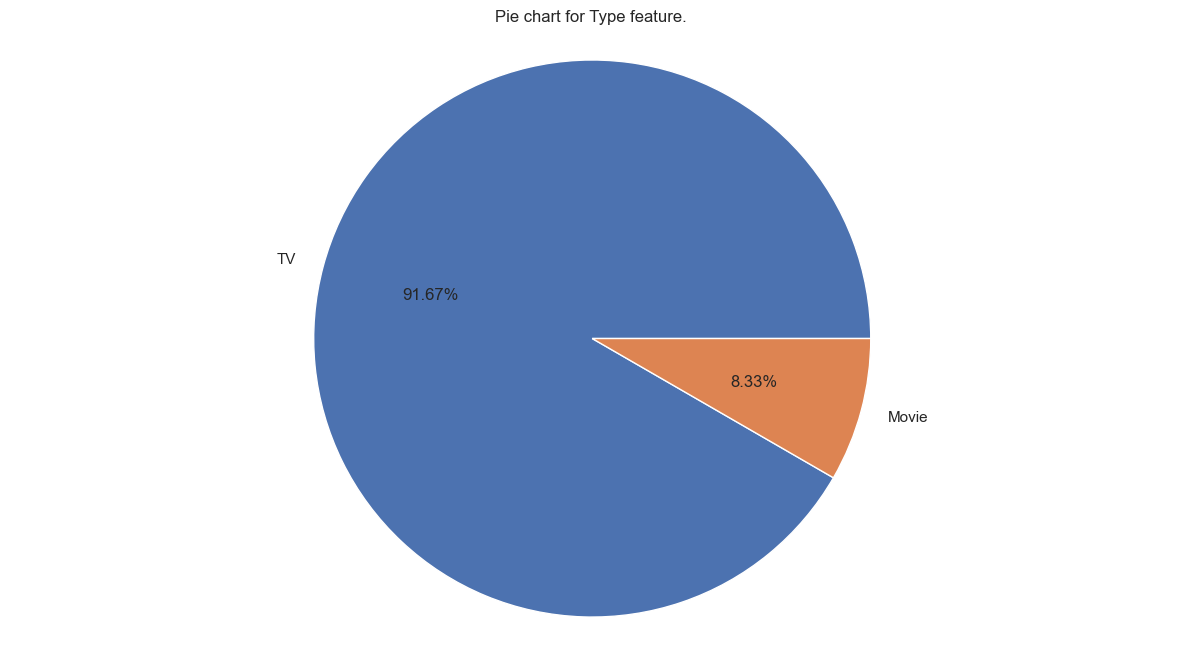

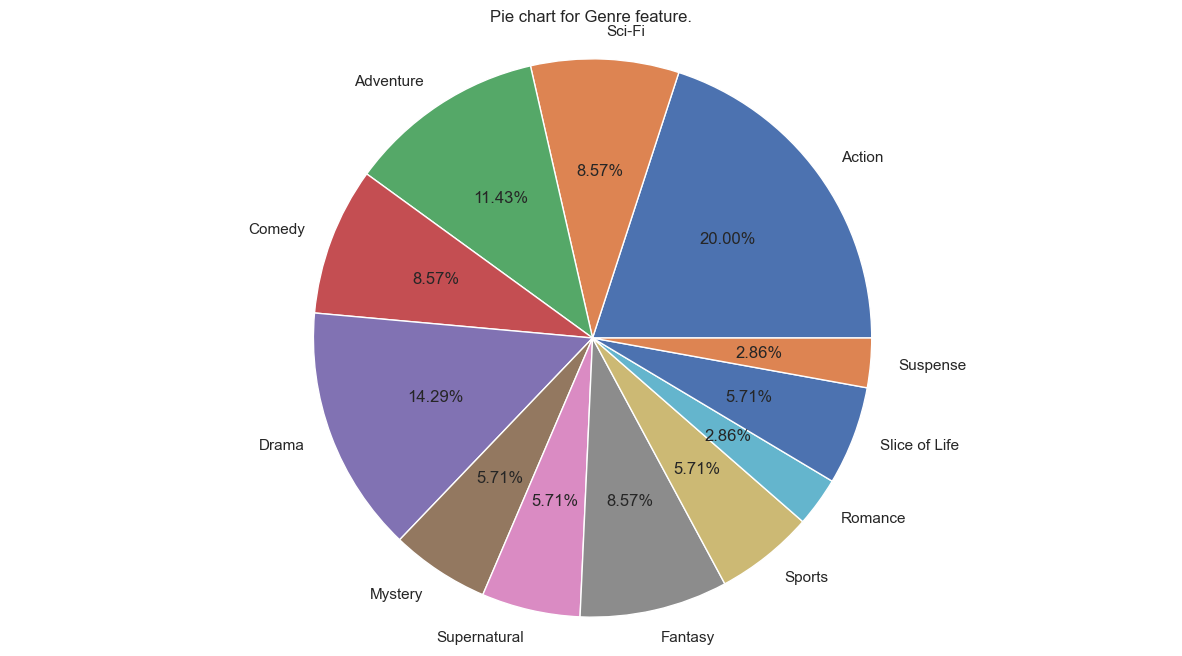

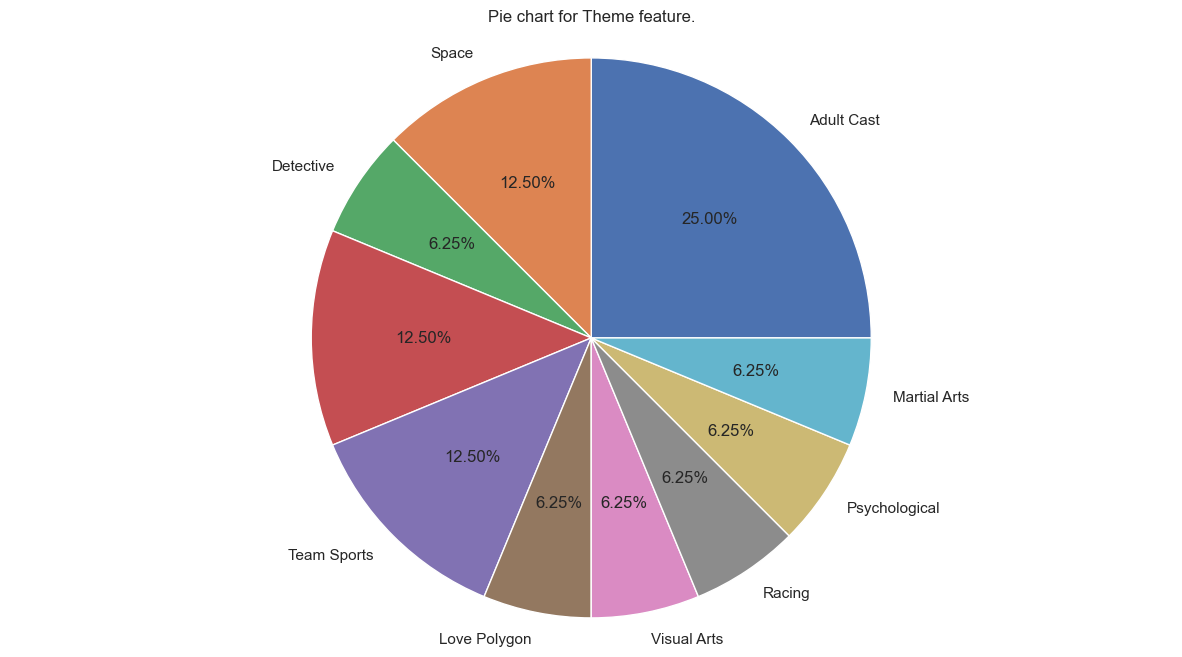

In [135]:
from collections import Counter
typedata = Counter(anime_copy["Type"])
all_genres = []
for item in anime_copy["Genre"]:
    item = item.strip().split(',')
    all_genres.extend(item)
genredata = Counter(all_genres)

all_themes = []
for item in anime_copy["Theme"]:
    item = item.strip().split(',')
    all_themes.extend(item)
themedata = Counter(all_themes)

pieplot(typedata, "Type")

pieplot(genredata, "Genre")

pieplot(themedata, "Theme")

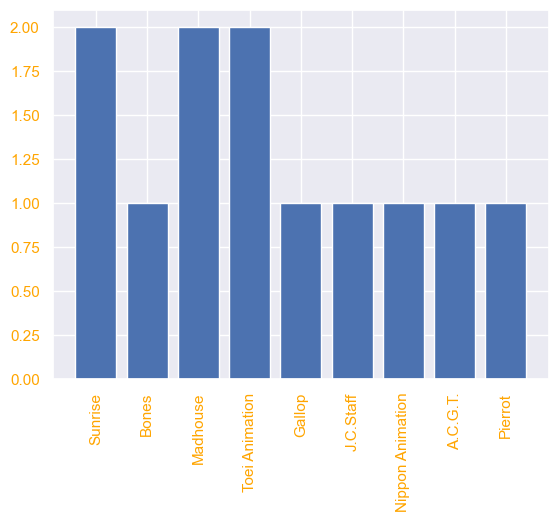

In [124]:
# Process the genre column to split on comma and append resulting
# genres all to a single list
def annotate(self, ax, title, xax, yax, fs = 16):
        ax.set_title(title, fontsize = fs)
        ax.set_xlabel(xax, fontsize = fs - 2)
        ax.set_ylabel(yax, fontsize = fs - 2)

all_Producers = []
for item in anime_copy["Studios"]:
    item = item.strip()
    all_Producers.extend(item.split(','))

# Count the number of items in the genre and create a dataframe
c = Counter(all_Producers)

# make a list from the keys view
bars = list(c.keys()) 
x_pos = np.arange(len(bars))

# make a list from the values
height = list(c.values())  

# Create bars
plt.bar(x_pos, height)

# Create names on the x-axis
plt.xticks(x_pos, bars, color='orange',rotation=90)
plt.yticks(color='orange')

# Show graphic
plt.show()

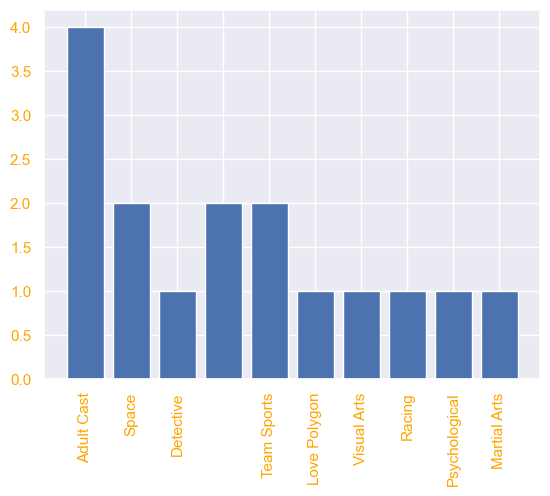

In [123]:
# Process the genre column to split on comma and append resulting
# genres all to a single list
def annotate(self, ax, title, xax, yax, fs = 16):
        ax.set_title(title, fontsize = fs)
        ax.set_xlabel(xax, fontsize = fs - 2)
        ax.set_ylabel(yax, fontsize = fs - 2)

all_Producers = []
for item in anime_copy["Theme"]:
    item = item.strip()
    all_Producers.extend(item.split(','))

# Count the number of items in the genre and create a dataframe
c = Counter(all_Producers)

# make a list from the keys view
bars = list(c.keys()) 
x_pos = np.arange(len(bars))

# make a list from the values
height = list(c.values())  

# Create bars
plt.bar(x_pos, height)

# Create names on the x-axis
plt.xticks(x_pos, bars, color='orange',rotation=90)
plt.yticks(color='orange')

# Show graphic
plt.show()

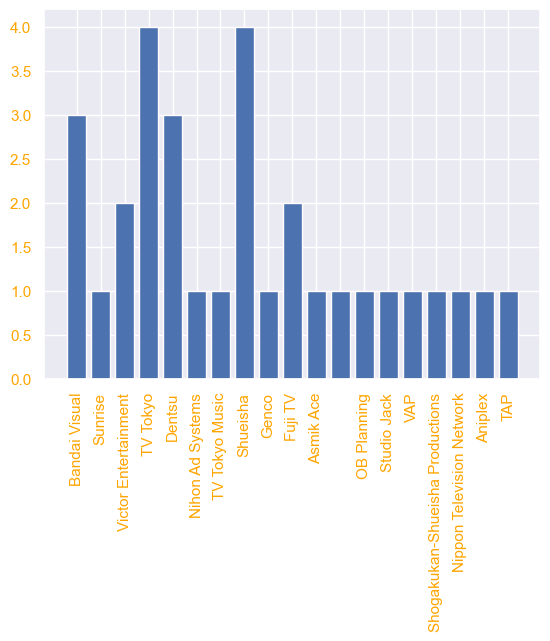

In [121]:
# Process the genre column to split on comma and append resulting
# genres all to a single list
def annotate(self, ax, title, xax, yax, fs = 16):
        ax.set_title(title, fontsize = fs)
        ax.set_xlabel(xax, fontsize = fs - 2)
        ax.set_ylabel(yax, fontsize = fs - 2)

all_Producers = []
for item in anime_copy["Producers"]:
    item = item.strip()
    all_Producers.extend(item.split(','))

# Count the number of items in the genre and create a dataframe
c = Counter(all_Producers)

# make a list from the keys view
bars = list(c.keys()) 
x_pos = np.arange(len(bars))

# make a list from the values
height = list(c.values())  

# Create bars
plt.bar(x_pos, height)

# Create names on the x-axis
plt.xticks(x_pos, bars, color='orange',rotation=90)
plt.yticks(color='orange')

# Show graphic
plt.show()

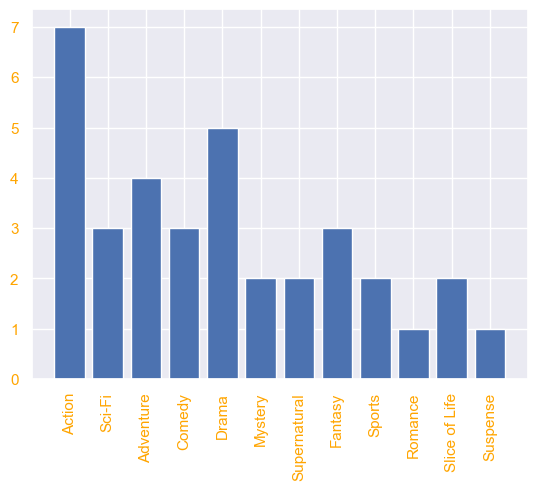

In [162]:
# Process the genre column to split on comma and append resulting
# genres all to a single list
def annotate(self, ax, title, xax, yax, fs = 16):
        ax.set_title(title, fontsize = fs)
        ax.set_xlabel(xax, fontsize = fs - 2)
        ax.set_ylabel(yax, fontsize = fs - 2)

all_genres = []
for item in anime_copy["Genre"]:
    item = item.strip()
    all_genres.extend(item.split(','))

# Count the number of items in the genre and create a dataframe
c = Counter(all_genres)
# make a list from the keys view
bars = list(c.keys()) 
x_pos = np.arange(len(bars))

# make a list from the values
height = list(c.values())  

# Create bars
plt.bar(x_pos, height)

# Create names on the x-axis
plt.xticks(x_pos, bars, color='orange',rotation=90)
plt.yticks(color='orange')

# Show graphic
plt.show()



In [106]:
a

['Action',
 'Sci-Fi',
 'Adventure',
 'Comedy',
 'Drama',
 'Mystery',
 'Supernatural',
 'Fantasy',
 'Sports',
 'Romance',
 'Slice of Life',
 'Suspense']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

- Barplot --> Type vs Episodes
- Barplot --> Type vs Rating
- Barplot --> top Producer by year (producer or publisher or whatever)
- Barplot --> Top 5 producers by year (producer or publisher or whatever)
- Countplot --> Genre
- Countplot --> Audience
- Countplot --> Type
- Heatmap --> Rating, Genre and Type
- Heatmap --> occurrences of Genre and Type
- Histogram --> Rating
- Pieplot --> Genre
- Pieplot --> Type
- Scatter --> Rating vs Episodes
- Scatter --> Rating vs Type
- boxplot --> episodes and type
- boxplot --> members and type
- violinplot --> episodes and type
- violinplot --> members and type

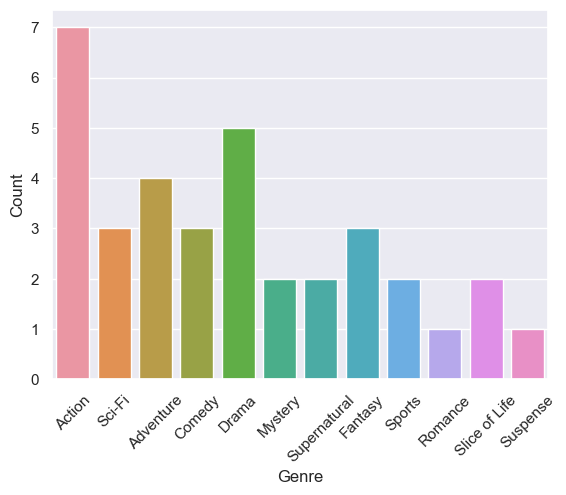

In [167]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Process the genre column to split on comma and append resulting
# genres all to a single list
all_genres = []
for item in anime_df["Genre"]:
    item = item.strip()
    all_genres.extend(item.split(','))
# Count the number of items in the genre and create a dataframe
c = Counter(all_genres)

all_genres_df=pd.DataFrame.from_dict(c,orient='index').reset_index()

all_genres_df=all_genres_df.rename(columns={'index':'Genre', 0:'Count'})

bar_plot = sns.barplot(x=all_genres_df["Genre"],y=all_genres_df["Count"])

plt.xticks(rotation=45)
plt.show()

In [1]:
import seaborn as sns

In [6]:
sns.distplot(anime_df['Rank'])

NameError: name 'anime_df' is not defined

In [3]:
Ranks = sns.load_dataset("Rank")
sns.histplot(data=Ranks, x="flipper_length_mm")

ValueError: 'Rank' is not one of the example datasets.

# V.5

In [ ]:
'''
Creating time variables.
'''
current_time = time.strftime("%H_%M_%S",time.localtime())
date = datetime.now()
actual_date = date.strftime("%Y_%m_%d")

'''
Preparing folder variables.
'''
os.chdir(os.path.dirname(sys.path[0])) # Este comando hace que el notebook sea la ruta principal y poder trabajar en cascada
folder_path = sys.path[0]
data_path = os.path.join(folder_path,"data") # Here we will save the csv that later will be created
logs_path = os.path.join(data_path,"logs") # Here we will save the log files

#Remove the limit to see the df
pd.set_option('display.max_columns', None)

#Creating the necessary lists
anime_list = []
missing_requests_list = []
resource_does_not_exist = []

'''
Creates the folders needed to store data for the current day (in case the folders does not exist).
'''
def create_folder(name):
    try:
        os.makedirs(os.path.join(folder_path,str(name)))
    except FileExistsError:
        print("The folder data already exist")
        pass
    try:
        os.mkdir(os.path.join(data_path,str("logs")))
        print("The folder",str("logs" +'_'+ actual_date),"was created")
    except FileExistsError:
        print("The folder",str(name +'_'+ actual_date),"already exist")
        pass
create_folder("data")

'''
To check if there is an empty value. If the category is empty, it returns None.
'''
def try_it(i):
    try:
        return i["name"]
    except:
        return None

'''
Def with a try check to get the finishing time of an anime, in case the anime is a movie, then it returns the release time.
If the anime is not a movie, it checks for the finishing time. If there is no finishing time, it returns None 
'''
def movie():
    try:
        if ( char["type"] == "Movie" or char["type"] == "OVA" or char["type"] == "Special" or char["type"] == "Music"): # if this one of this options is correct
            return data["aired"]["prop"]["from"]["year"]
        elif char["status"] == "Currently Airing":
            return 999 #Still Airing
        elif char["aired"]["prop"]["to"]["year"] == None:
            return 666 # There is no information
        else:
            return char["aired"]["prop"]["to"]["year"]
    except:
        return 0 #No information about it

r = requests.get("https://api.jikan.moe/v4/anime")    
url = "https://api.jikan.moe/v4/anime"
 # request to a web page (url)
data = r.json() # creating a variable for all the info we get
#print(data)
n_pages = data['pagination']['last_visible_page']

for page in range (1,n_pages +1):
    r_page = requests.get(url + '?page=' + str(page)) # request to a web page (url)
    content = r_page.json()
    print (page)
    data = content["data"]
    time.sleep(1)
    for char in data: #Already 1 to 13000 of 25850 #Loop to go thru a range of chosen numbers
        #time.sleep(1)
        try: # First try yo check if the page exist or not
            # Creation of the necessary dictionary o store the values in each loop # We specify which information to get in each Item
            anime_dict = {"Cover" : char["images"]["jpg"]["large_image_url"] if char["images"]["jpg"]["large_image_url"]  else None,
                        "English_Title" : char["title"] if char["title"]  else None,
                        "Japanses_Title" : char["title_japanese"] if char["title_japanese"]  else None,
                        "Type" : char["type"] if char["type"]  else None,
                        "Source" : char["source"] if char["status"] else None,
                        "Audience" : [try_it(i) for i in char["demographics"]], # List comprehension calling the Def try_it
                        "N_Episodes" : (int(char["episodes"])) if char["episodes"] else 0,
                        "Duration" : char["duration"] if char["duration"]  else None,
                        "Status" : char["status"] if char["status"] else None,
                        "Rating" : char["rating"] if char["rating"] else None,
                        "Score" : char["score"] if char["score"]  else None,
                        "Scored_by" : char["scored_by"] if char["scored_by"]  else None,
                        "Rank" : (int(char["rank"])) if char["rank"] else None,
                        "Season" : char["season"] if char["season"] else None,
                        "Genre" : [try_it(i) for i in char["genres"]],# List comprehension calling the Def try_it
                        "Theme" : [try_it(i) for i in char["themes"]],# List comprehension calling the Def try_it
                        "Released" : (int(char["aired"]["prop"]["from"]["year"])) if char["aired"]["prop"]["from"]["year"] else None, # If else in one line
                        "Finished" : int(movie()), 
                        "Studios" : [try_it(i) for i in char["studios"]],# List comprehension calling the Def try_it
                        # "Licensors" : [try_it(i) for i in char["licensors"]],# List comprehension calling the Def try_it
                        "Producers" : [try_it(i) for i in char["producers"]]# List comprehension calling the Def try_it
                        }
                        
            anime_list.append(anime_dict) # Append the loop info to anime_list
            #time.sleep(1) # we use here a time sleep cuz if we are to fast asking for information, the server might block us
        # Ending of the first try specifying the error
        except:
            if r_page.status_code == 429: #If there is a 429 error we show it on screen and tell us the respuesta.reason
                missing_requests_list.append(id)
                print (f"El código de estado de la petición es: {r_page.status_code}. Estatus {r_page.reason}. No se puede recoger información de la página {id}\n")
            else:
                resource_does_not_exist.append(id) #If there is a any other error we show it on screen and tell us the respuesta.reason
                print (f"El código de estado de la petición es: {r_page.status_code}. Estatus {r_page.reason}. No se puede recoger información de la página {id}\n")
            continue

# References & More Reading

- [MyAnimeList.net](https://myanimelist.net/)
- [from Data to Viz](https://www.data-to-viz.com/#connectedscatter)
- [Seaborn Documentation](https://seaborn.pydata.org/)
- [Matplotlib Documentation](https://matplotlib.org/)
- [Data Visualization con pandas y seaborn](https://medium.com/ironhack/data-visualization-con-pandas-y-seaborn-1044906af34f)
- [The Python Graph Gallery](https://www.python-graph-gallery.com/)

# separate produces in more columns

```````
df[['organ', 'dimension']] = df['organ_dimension'].str.split('_', expand=True)
df.head()
```````
https://stackoverflow.com/questions/37600711/pandas-split-column-into-multiple-columns-by-comma

https://stackoverflow.com/questions/73738504/how-to-label-encode-comma-separated-text-in-a-dataframe-column-in-python

https://stackoverflow.com/questions/37600711/pandas-split-column-into-multiple-columns-by-comma

https://stackoverflow.com/questions/33271098/python-get-a-frequency-count-based-on-two-columns-variables-in-pandas-datafra